# Regresia logistică

**Termen de predare: 27 martie 2024, ora 23:00**

Se vor folosi type annotations pentru variabile, parametrii tuturor funcțiilor, tipuri de retur. Se vor folosi docstrings pentru toate funcțiile. Neîndeplinirea acestei cerințe duce la înjumătățirea punctajului.

Se acordă doua puncte din oficiu. Fișierul va fi denumit tema3_ia_nume_prenume.ipynb. Verificați înainte de trimitere faptul ca execuția celulelor de sus în jos funcționează corespunzător. Aserțiunile sunt obligatoriu a fi indeplinite. Suplimentar, puteti face si alte verificari.

Resurse utile:

[1] [Cross entropy for dummies](https://towardsdatascience.com/cross-entropy-for-dummies-5189303c7735)

[2] [Understanding logistic regression](https://towardsdatascience.com/understanding-logistic-regression-step-by-step-704a78be7e0a)

[3] [Cross entropy log loss and intuition behind it](https://towardsdatascience.com/cross-entropy-log-loss-and-intuition-behind-it-364558dca514)

[4] [Cross entropy (a se vedea secţiunea "Relation with log-likelihood")](https://en.wikipedia.org/wiki/Cross_entropy)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import functools
import pandas as pd
from typing import Union, Literal, List, Tuple, Dict, Any, Optional

print('Versions:')
print(f'{np.__version__=}')
print(f'{pd.__version__=}')
print(f'{csv.__version__=}')

plt.rc('font', **{'size' : 18})

Versions:
np.__version__='1.26.4'
pd.__version__='2.1.4'
csv.__version__='1.0'


In [2]:
# !pip install tableprint
import tableprint as tab

## Introducere

Regresia liniară 'potriveşte' o funcţie liniară (polinomială) folosind un set de date $X$, pe tot domeniul $\mathbb{R}$, $linreg(x) : \mathbb{R}^m \rightarrow \mathbb{R}$. Regresia logistică are acelaşi domeniu, însă codomeniul este un set mult mai restrâns, şi anume $logreg(x) : \mathbb{R}^n \rightarrow (0, 1)$. Aceasta încearcă să prezică probabilitatea ca elementul $x \in X$ să facă parte din clasa pozitivă.

Această probabilitate o notăm cu $P(y=1|x,\theta)$, şi o interpretăm ca fiind probabilitatea asociată răspunsului $x^T \theta$ calculat de regresia clasică, în condiţiile în care cunoaştem feature-urile $X$ şi parametrii $\theta$ ai modelului.

Ideea este că pentru fiecare intrare $x$, modelul regresiei logistice asociază o probabilitate. Vom arăta cum alegem funcţia care calculează probabilitatea folosind răspunsul regresiei liniare $x^T \theta$.

Pornim de la o funcţie care are ca parametru o probabilitate şi care mapează intervalul $(0,1)$ în toată axa reală $\mathbb{R}$. Observăm cum funcţia $f_1(p) = \frac{p}{1-p}$ mapează probabilitatea în $\mathbb{R}^+$, iar dacă aplicăm logaritmul, funcţia $f_2(p) = log\left(\frac{p}{1-p}\right)$ mapează intervalul $(0, 1)$ în toată axa reală $\mathbb{R}$:

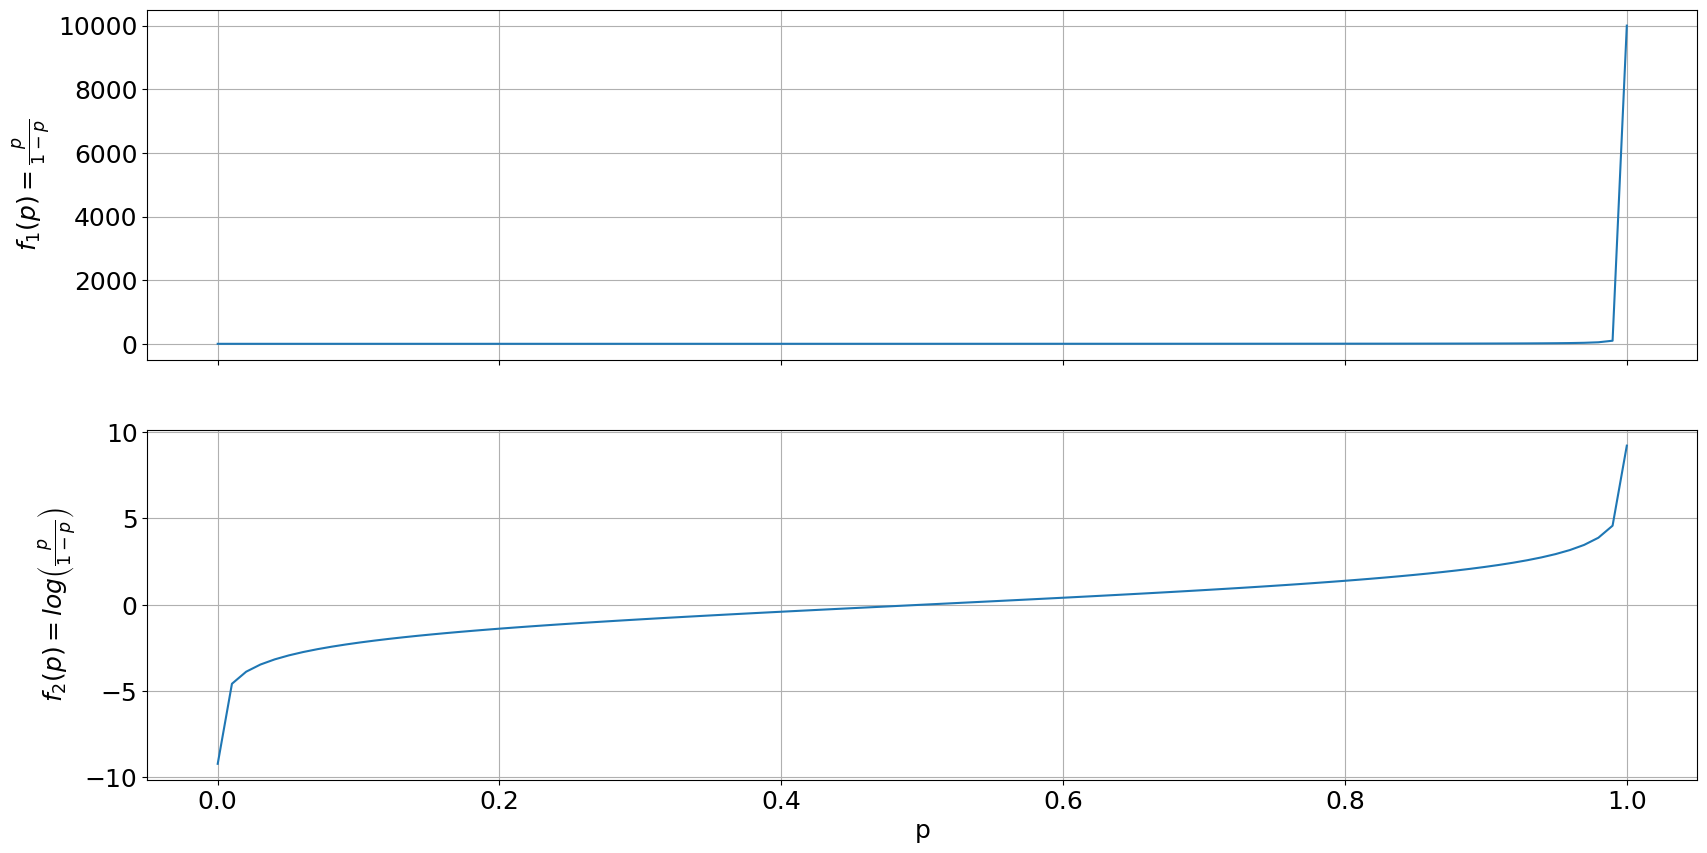

In [3]:
f1 = lambda x: x / (1 - x)
f2 = lambda x: np.log(x / (1 - x))
x = np.linspace(1e-4, 1-1e-4, 100)

fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(x, f1(x)) ; ax[1].plot(x, f2(x))
ax[0].set_ylabel(r'$f_1(p) = \frac{p}{1-p}$') ; ax[0].grid()
ax[1].set_xlabel('p') ; ax[1].set_ylabel(r'$f_2(p) = log\left(\frac{p}{1-p}\right)$') ; ax[1].grid()
plt.show()

Observaţi că dacă răspunsul dat de regresie este 0 ($f_2(p) = 0$), probabilitatea asociată este 0.5. Ne interesează ca răspunsul calculat de regresie (care poate fi orice valoare de pe axa reală) să fie egal cu această funcţie de probabilitate:

$$h_{\theta}(x) = x^T \theta = log\left(\frac{p}{1-p}\right)$$

Mai departe, prin câteva transformări algebrice, putem arăta că:

$$\hat{y} = P(y=1|x, \theta) = p = \frac{1}{1 + e^{-h_{\theta}(x)}}$$

Avem astfel o funcţie care mapează $x$ şi parametrii modelului $\theta$ într-o probabilitate. Funcţia este denumită funcţie logistică.

În realitate, avem setul de date $X$ şi asociat fiecărui $x_i$, $i=1 \dots m$, o valoare binară $y_i \in \{0, 1\}$. De fapt, setul de date $X$ este caracterizat de o distribuţie de probabilitate foarte simplă, distribuţie în care probabilităţile pot lua doar valorile 0 şi 1. Dacă am pune valorile $x_i$ pe abscisă şi valorile $y_i$ pe ordonată, graficul distribuţiei ar fi foarte accidentat - în fond, y ia doar două valori.

Am vrea ca modelul nostru caracterizat de coeficienţii $\theta$ să se 'potrivească' cât mai bine peste această distribuţie dată iniţial - probabil peisajul funcţiei de distribuţie a modelului nu mai este atât de rugos, ci mai neted (continuu, vălurit). Bineînteles acest exemplu este unul exagerat, în realitate spaţiul de intrare $X$ este unul $m$ dimensional, nu 1-dimensional cum am presupus aici ca să ne imaginăm reprezentarea distribuţiilor de probabilitate.

Pentru ca să putem compara însă 'cât de bine' se potriveşte distribuţia modelului pe care îl învăţăm cu distribuţia iniţială, avem nevoie de o măsură a acestor distribuţii. Pentru aceasta vom introduce noţiunea de entropie ca măsură a informaţiei.

## Regresia logistică binară

Funcţia de cost pentru regresia logistică binara este dată de binary cross-entropy, scrisă sub formă vectorială astfel:

$$
J(\theta) = -\frac{1}{m} \left(\mathbf{y}^t \cdot \ln \hat{\mathbf{y}} + (1-\mathbf{y})^t \cdot \ln ( \mathbb{1}_m - \hat{\mathbf{y}}) \right) 
$$

Gradientul functiei de cost este:

$$
\nabla_{\theta} J(\theta) = \frac{1}{m} \mathbf{X}^t (\hat{\mathbf{y}} - \mathbf{y})
$$

Modificarea ponderilor din vectorul $\boldsymbol{\theta}$ se face la fiecare iteratie cu:
$$
\boldsymbol{\theta} = \boldsymbol{\theta} - \alpha\frac{1}{m} \mathbf{X}^t (\hat{\mathbf{y}} - \mathbf{y})
$$
cu $\alpha > 0$ rata de invatare. 

### Încărcarea setului de date

In [4]:
path_train = './data/mnist_train.csv'
path_test = './data/mnist_test.csv'

train_set = pd.read_csv(path_train, header=None).values
test_set = pd.read_csv(path_test, header=None).values

assert train_set.shape == (60000, 785)
assert test_set.shape == (10000, 785)

In [5]:
# train_set si test_set sunt matrice care contin pe prima coloana clasa, daca ca o cifra de la 0 la 9
# imaginea cifrei este pastrata incepand de pe coloana 1 pana la terminare
# Decupati in train_x doar imaginile iar in train_y doar clasa,
# si faceti acelasi lucru si pentru test_x si test_y

print(f'{train_set=}')

train_x, train_y = train_set[:, 1:], train_set[:, 0]
test_x, test_y = test_set[:, 1:], test_set[:, 0]

assert train_x.shape == (60000, 784)
assert train_y.shape == (60000,)
assert test_x.shape == (10000, 784)
assert test_y.shape == (10000,)

train_set=array([[5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0],
       [8, 0, 0, ..., 0, 0, 0]], dtype=int64)


Să vizualizăm setul de date. Vom observa primele 16 linii din setul de antrenare:

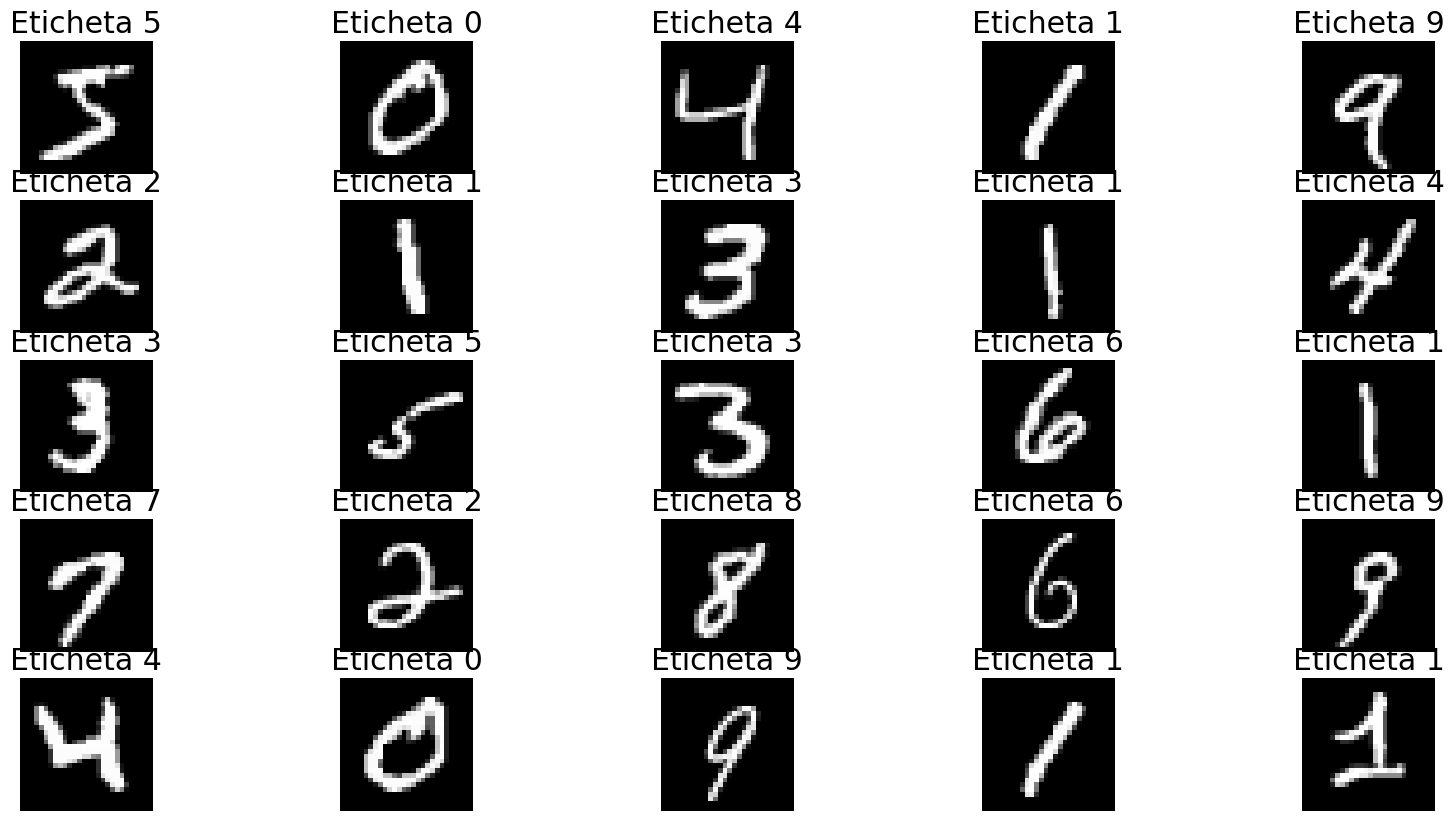

In [6]:
def show_samples(x_set: np.ndarray, y_set: np.ndarray) -> None:
    """
    Functie care afiseaza primele 25 de imagini din x_set
    si eticheta lor din y_set
    :param x_set: np.ndarray de dimensiunea (N, 784)
    :param y_set: np.ndarray de dimensiunea (N,)
    :return: None 
    """
    size = x_set.shape[0]
    
    fig, ax = plt.subplots(size // 5, 5, figsize=(20, 10))
    for k in range(size):
        row, col = k // 5, k % 5
        
        # Make those columns into a array of 8-bits pixels
        # The pixel intensity values are integers from 0 to 255
        pixels = np.array(x_set[k], dtype='uint8')    
        
        # Reshape the array into 28 x 28 array (2-dimensional array)
        n = int(np.sqrt(len(pixels)))
        assert n**2 == len(pixels)
        pixels = pixels.reshape(n, n)
        ax[row, col].imshow(pixels, cmap='gray')
        ax[row, col].set_title('Eticheta {label}'.format(label=y_set[k]))
        ax[row, col].axis('off')

    plt.show()
    
show_samples(train_x[:25, :], train_y[:25])

Pentru regresia binomială, ne interesează să clasificăm deocamdată doar imaginile corespunzătoare a două clase, de exemplu pentru cifrele '8' (clasa pozitiva) şi '4' (clasa negativa). Vom defini seturile care 'decupează' doar aceste două clase din seturile date:

In [7]:
# Filtrati din seturile mari doar acele sample-uri corespunzatoare cifrelor 8 si 4
# determinati vectorii logici cu True pentru indicii pt care clasele din vectorii y sunt 8 sau 4 si False in rest 
# (cifre != 8, 4)
labels_0_1_train = (train_y == 8) | (train_y == 4)
labels_0_1_test = (test_y == 8) | (test_y == 4)

assert labels_0_1_train.shape == (60000,), f'{labels_0_1_train.shape=}'
assert labels_0_1_test.shape == (10000,), f'{labels_0_1_test.shape=}'

assert labels_0_1_train.sum() == 11693, f'{labels_0_1_train.sum()=}'
assert labels_0_1_test.sum() == 1956, f'{labels_0_1_test.sum()=}'

# # Filtrati din seturile mari doar acele sample-uri corespunzatoare cifrelor 8 si 4. 
# Puteti folosi reshape pentru vectorii y 
# Folositi vectorii logici labels_0_1_train si labels_0_1_test pentru filtrare
train_x_bin, train_y_bin = train_x[labels_0_1_train], train_y[labels_0_1_train].reshape(-1, 1)

test_x_bin, test_y_bin = test_x[labels_0_1_test], test_y[labels_0_1_test].reshape(-1, 1)

assert train_x_bin.shape == (11693, 784), f'{train_x_bin.shape=}'
assert train_y_bin.shape == (11693, 1), f'{train_y_bin.shape=}'
assert test_x_bin.shape == (1956, 784), f'{test_x_bin.shape=}'
assert test_y_bin.shape == (1956, 1), f'{test_y_bin.shape=}'

In [8]:
# Momentan, vectorii 'y' sunt plini cu 8 si 4. Clasa '8' va fi clasa pozitiva (1), clasa '4' clasa negativa (0). 
# Trebuie deci sa suprascriem in cei 2 vectori 'y' valorile 8 cu 1 si 4 cu 0

# verificam ca etichetele din 'y' sunt doar 8 sau 4:
assert set(train_y_bin.flatten()) == {8, 4}
assert set(test_y_bin.flatten()) == {8, 4}

# toate etichetele de 8 vor fi trecute in 1; toate etichetele 4 vor fi trecute in 0
# train_y_bin = np.where(train_y_bin == 8, 1, train_y_bin)
train_y_bin[train_y_bin == 8] = 1 # setare 8 -> 1
# train_y_bin = np.where(train_y_bin == 4, 0, train_y_bin)
train_y_bin[train_y_bin == 4] = 0 # setare 4-> 0

# toate etichetele de 8 vor fi trecute in 1; toate etichetele 4 vor fi trecute in 0
# test_y_bin = np.where(test_y_bin == 8, 1, test_y_bin)
test_y_bin[test_y_bin == 8] = 1 # setare 8 -> 1
# test_y_bin = np.where(test_y_bin == 4, 0, test_y_bin)
test_y_bin[test_y_bin == 4] = 0 # setare 4-> 0


# verificam ca etichetele din 'y' sunt acum 0 sau 1:
assert set(train_y_bin.flatten()) == {0, 1}
assert set(test_y_bin.flatten()) == {0, 1}

assert train_y_bin.sum() == 5851, 'Ar trebuie sa fie 5851 exemple de clase pozitive in setul de antrenare'
assert test_y_bin.sum() == 974, 'Ar trebuie sa fie 974 exemple de clase pozitive in setul de testare'

 La fel ca si la regresia liniară, prima coloană trebuie să fie formată doar din cifra 1:

In [9]:
def add_ones_column(x: np.ndarray) -> np.ndarray:
    """
    Returns a matrix with first column filled with 1 and the other columns being x's columns.
    :param x: np.ndarray of shape (N, D)
    :return: np.ndarray of shape (N, D+1)
    """
    # hstack - stack arrays in sequence horizontally (column wise)
    # np.ones - Return a new array of given shape and type, filled with ones.
    x_ext: np.ndarray = np.hstack((np.ones((x.shape[0], 1)), x))
    return x_ext

train_x_bin_ext: np.ndarray = add_ones_column(train_x_bin)
test_x_bin_ext: np.ndarray = add_ones_column(test_x_bin)

assert train_x_bin_ext.shape == (11693, 785)
assert test_x_bin_ext.shape == (1956, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)

Trasaturile trebuie normalizate, valoarea maximă actuală fiind 255. Normalizarea urmăreşte ca toate featurile rezultate să fie în intervalul \[0, 1\], deci vom împărţi la valoarea maximă.

In [10]:
def normalize(x: np.ndarray) -> np.ndarray:
    """
    Normalization means division by 255.
    
    Args:
        x: feature matrix, shape m * n. It will not be changed by this code.
    
    Returns:
        matrix with scaled values between 0 and 1, of same shape
    """
    return x / 255

train_x_bin_ext: np.ndarray = add_ones_column(normalize(train_x_bin))
test_x_bin_ext: np.ndarray = add_ones_column(normalize(test_x_bin))

assert train_x_bin_ext.shape == (11693, 785)
assert test_x_bin_ext.shape == (1956, 785)
assert np.all(train_x_bin_ext[:, 0] == 1)
assert np.all(test_x_bin_ext[:, 0] == 1)
assert np.all(train_x_bin_ext <= 1)
assert np.all(test_x_bin_ext <= 1)
assert np.all(train_x_bin_ext >= 0)
assert np.all(test_x_bin_ext >= 0)

Calculăm funcţia sigmoidă, $sigmoid(z) = \frac{1}{1 + e^{-z}}$ respectiv $\hat y = h(x, \theta) = sigmoid \left( X  \theta \right)$:

In [11]:
def sigmoid(z: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """ 
    Compute the sigmoid of z.
    :param z: A scalar or numpy array of any size.
    :return: sigmoid(z)
    """
    return 1 / (1 + np.exp(-z))

assert sigmoid(0) == 0.5
assert np.abs(sigmoid(1) - 0.731058) < 1e-6

def h(x: Union[float, np.ndarray], theta: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
    """
    Compute the sigmoid of the dot product of x and theta.
    :param x: A scalar or numpy array of any size.
    :param theta: A scalar or numpy array of any size.
    :return: sigmoid(x * theta) 
    """
    return sigmoid(np.dot(x, theta))

assert np.abs(h(np.array([1., 0., 1., 1]), np.array([2., 1., 0., 0.5])) - 0.924141) < 1e-6

Calculăm funcţia de cost cu regularizare de data aceasta (atenţie, coeficientul $\theta_0$ nu se regularizează):

\begin{align}
J(\boldsymbol\theta) & = \underbrace{-\frac{1}{m} \sum\limits_{i=1}^m \left[y^{(i)}\cdot \ln h_{\boldsymbol\theta}(\mathbf{x}^{(i)}) + (1-y^{(i)})\cdot \ln (1- h_{\boldsymbol\theta}(\mathbf{x}^{(i)})) \right]}_{\text{Eroarea de calitate}} 
\\
& + \underbrace{\frac{\lambda}{2} \sum\limits_{j=1}^n \theta_j^2}_{\text{termenul de regularizare}}
%\label{eq:JCrossEntropyRegularizare}
\\
& = 
\underbrace{-\frac{1}{m} \sum\limits_{i=1}^m \left[y^{(i)}\cdot \ln \hat y^{(i)}  + (1-y^{(i)})\cdot \ln (1- \hat y^{(i)}) \right]}_{\text{Eroarea de calitate}} 
\\
& + \underbrace{\frac{\lambda}{2} \sum\limits_{j=1}^n \theta_j^2}_{\text{termenul de regularizare}}
\\
& = -\frac{1}{m} \left(\mathbf{y}^t \cdot \ln\hat{\mathbf{y}}  + (\mathbb{1}-\mathbf{y})^t \cdot \ln(\mathbb{1}-\hat{\mathbf{y}})\right) + \frac{\lambda}{2} \| \boldsymbol\theta[1:]  \|^2_2
\end{align}

unde $\boldsymbol\theta[1:]$ este vectorul format din toate componentele lui $\boldsymbol\theta$ mai puțin prima, iar $\| \mathbf{v} \|_2$ este norma Euclidiană a vectorului $\mathbf{v}$.

In [32]:
def cost(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> float:
    """
    Cost function includes also regularization
    
    Args:
        x: matricea de design a feature-urilor, dimensiune m x (n+1)
        y: vectorul ground truth, dimensiune m x 1
        theta: vectorul ponderilor modelului, dimensiune (n+1) x 1
        
    Returns:
        costul, ca scalar
    """
    assert x.shape[1] == theta.shape[0]
    assert x.shape[0] == y.shape[0]
    assert theta.shape[1] == y.shape[1] == 1
    assert lmbda >= 0
    # calculam y hat folosind modelul din functia h:
    y_hat: np.Union[np.ndarray, float] = h(x, theta)
    # calculam eroarea de calitate
    m: int = x.shape[0]
    j1: float= -1/m * (np.dot(y.T, np.log(y_hat)) + np.dot((1 - y).T, np.log(1 - y_hat)))
    # calculam termenul de regularizare
    j2:float = lmbda / 2 * np.dot(theta[1:].T, theta[1:])
    return (j1 + j2).flatten()
    

np.random.seed(11)
n: int = train_x_bin_ext.shape[1]
theta: np.ndarray = np.random.randn(n).reshape(n, 1)
assert np.abs(cost(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2) - 80.963789) < 1e-6

Calculăm gradientul, folosind expresia determinată anterior, şi ţinând seama de termenul de regularizare:

$$
\nabla_{\boldsymbol{\theta}} J(\boldsymbol{\theta}) = \frac{1}{m} \mathbf{X}^t(\hat{\mathbf{y}} - \mathbf{y}) + \lambda (0, \theta_1, \dots, \theta_n)^t
$$

In [13]:
def grad(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> np.ndarray:
    """
    Calculul gradientului pentru functia de eroare, incluzand termenul de regularizare
    
    Args:
        x: matricea feature-urilor, dimensiune m x (n + 1)
        y: vectorul evidentei, dimensiune m
        theta: vectorul coeficientilor, dimensiune n+1
        lmbda: coeficientul de regularizare
        
    Returns:
        gradientul, vector de n+1 elemente
    """
    m: int = x.shape[0]
    y_hat: Union[np.ndarray, float] = h(x, theta)
    g1: np.ndarray = 1/m * np.dot(x.T, y_hat - y)
    # gradientul termenului de calitate, fara regularizare
    
    theta_simple: np.ndarray = theta.copy()
    theta_simple[0] = 0
    g2: np.ndarray = lmbda * theta_simple
    # gradientul aferent termenului de regularizare
    
    g: np.ndarray = g1 + g2
    assert g.shape == theta.shape
    return g

np.random.seed(11)
n: int = train_x_bin_ext.shape[1]
theta: np.ndarray = np.random.randn(n).reshape(n, 1)
res: np.ndarray = grad(train_x_bin_ext, train_y_bin, theta=theta, lmbda=0.2)
assert res.shape == (785, 1)

Algoritmul de antrenare va stoca costul asociat fiecărei epoci într-o listă:

In [14]:
def accuracy(x_set: np.ndarray, y_set: np.ndarray, theta: np.ndarray) -> float:
    """
    Funcion which computes the accuracy of the model on the given set
    :param x_set: np.ndarray of shape (N, D)
    :param y_set: np.ndarray of shape (N, 1)
    :param theta: np.ndarray of shape (D, 1)
    :return: accuracy as a float
    """
    pred = ((h(x_set, theta) >= 0.5) * 1 == y_set)
    return 100.0 * sum(pred) / pred.shape[0]

In [15]:
# Set learning rate
alpha: float = 0.2

# Set regularization coefficient
lmbda: float = 0.5

# In x, we have m instances of n features each
# Create theta as a vector (n x 1)
n: int = np.shape(train_x_bin_ext)[1]
theta: np.ndarray = np.random.randn(n).reshape(n, 1)

# Do the training
epochs: int = 40
values: List[float] = []
accurracies: List[float] = []
for i in range(epochs):
    theta -= alpha * grad(train_x_bin_ext, train_y_bin, theta, lmbda)
    acc: float = accuracy(train_x_bin_ext, train_y_bin, theta)
    values.append(cost(train_x_bin_ext, train_y_bin, theta, lmbda))
    accurracies.append(acc)
    
print(f"last cost: {values[-1]}")

last cost: [0.40393562]


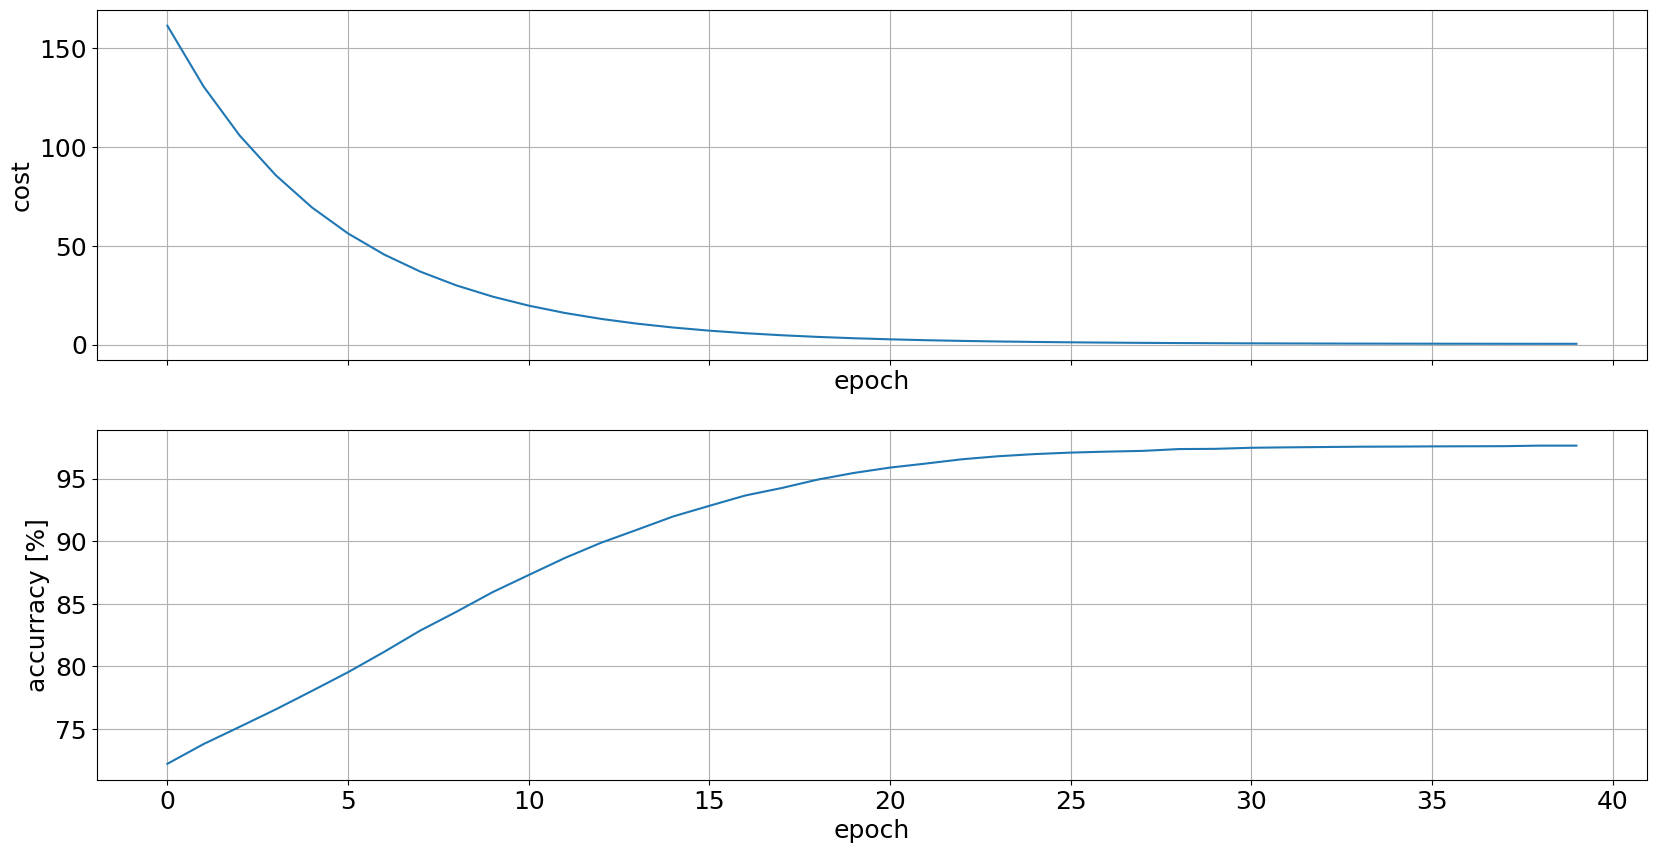

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot(range(len(values)), values)
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot(range(len(accurracies)), accurracies)
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

In [17]:
# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea si sa exprimam acest lucru procentual
pred = ((h(test_x_bin_ext, theta) >= 0.5) * 1 == test_y_bin)
print("accuracy: %2.2f%% for %d patterns" % (np.mean(pred)*100 , test_x_bin_ext.shape[0]))

# Calculam confusion matrix
# true positive: y = 1 and pred = 1
# true negative: y = 0 and pred = 0
# false positive: y = 0 and pred = 1
# false negative: y = 1 and pred = 0
pred = (h(test_x_bin_ext, theta) >= 0.5) * 1
tp = np.sum(np.logical_and(pred == 1, test_y_bin == 1))
tn = np.sum(np.logical_and(pred == 0, test_y_bin == 0))
fp = np.sum(np.logical_and(pred == 1, test_y_bin == 0))
fn = np.sum(np.logical_and(pred == 0, test_y_bin == 1))

headers = ['Confusion Matrix', 'pred: 0', 'pred: 1', 'pred: all'] 
table = [
    ['actual: 0', tn, fp, tn + fp],
    ['actual: 1', fn, tp, fn + tp],
    ['actual: all', tn + fn, fp + tp, tn + fn + fp + tp]]
tab.table(table, headers, width=16)

accuracy: 97.90% for 1956 patterns
╭──────────────────┬──────────────────┬──────────────────┬──────────────────╮
│ Confusion Matrix │          pred: 0 │          pred: 1 │        pred: all │
├──────────────────┼──────────────────┼──────────────────┼──────────────────┤
│        actual: 0 │              965 │               17 │              982 │
│        actual: 1 │               24 │              950 │              974 │
│      actual: all │              989 │              967 │             1956 │
╰──────────────────┴──────────────────┴──────────────────┴──────────────────╯


## Regresia logistică multinomială

In [18]:
# classes
k: int = 10

# Adaugam la features coloana de 1-uri
train_x_all_ext: np.ndarray = add_ones_column(normalize(train_x))
test_x_all_ext: np.ndarray = add_ones_column(normalize(test_x))

assert train_x_all_ext.shape == (60000, 785)
assert test_x_all_ext.shape == (10000, 785)
assert np.all(train_x_all_ext[:, 0] == 1)
assert np.all(test_x_all_ext[:, 0] == 1)
assert np.all(train_x_all_ext <= 1)
assert np.all(test_x_all_ext <= 1)
assert np.all(train_x_all_ext >= 0)
assert np.all(test_x_all_ext >= 0)

In [19]:
def one_hot(val: int, classes: int) -> np.ndarray:
    """
    Realizeaza 'one-hot encoding', conversia unui intreg la un array binar,
    care are 1 doar pe pozitia specificata de val
    
    Args:
        val: clasa ce trebuie encodata, un intreg intre {0, 1, ... K-1}
        classes: numarul de clase K
        
    Returns:
        un array de zerouri de lungime K, unde doar pe pozitia val avem o valoare 1
    """
    assert 0 <= val < classes
    result: np.ndarray = np.zeros((1, classes))
    result[0, val] = 1
    # instructiuni
    assert result.shape == (1, classes)
    return result

assert np.all(one_hot(7, k) == np.array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]))
assert np.all(one_hot(3, k) == np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]))

train_y_all: np.ndarray = np.concatenate([one_hot(int(i), k) for i in train_y])
test_y_all: np.ndarray = np.concatenate([one_hot(int(i), k) for i in test_y])
assert train_y_all.shape == (60000, 10)
assert test_y_all.shape == (10000, 10)
assert np.all((train_y_all != 0) == (train_y_all == 1))

Produsul $X \theta$ între matricea X de dimensiune (m, n) şi $\theta$ de dimensiune (n, k) va avea dimensiunea (m, k):

In [20]:
def prod(x: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Product between X of shape (m x n) and theta of shape (n x k)
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    return np.dot(x, theta)

m, n = train_x_all_ext.shape
np.random.seed(11)
theta: np.ndarray = np.random.randn(n, k)
assert prod(train_x_all_ext, theta).shape == (m, k)

Funcţia $softmax()$ va avea aceleaşi dimensiuni (m, k) şi trebuie să dea pe fiecare coloană suma 1. Se poate scrie compact calculul ei astfel:

$$softmax(X, \theta) = \frac{e^{X \theta}}{e^{X \theta} \cdot \mathbb{1}_k}$$

Termenul de la numitor, $e^{X \theta} \cdot \mathbb{1}_k$, nu mai este o matrice, ci un vector de dimensiunea (m, 1) (practic se realizează suma pe fiecare linie). Pentru realizarea împărţirii se realizează operaţia de broadcast.

In [21]:
def softmax(x: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """"
    Calculul functie softmax
    
    Args:
        x: feature-urile, dimensiune m x n
        theta: parametrii, de dimensiune n x k
        
    Returns:
        produsul lor de dimensiune m x k
    """
    assert x.shape[1] == theta.shape[0]
    # ... # cod...
    return np.exp(prod(x, theta)) / np.exp(prod(x, theta)).sum(axis=1).reshape(-1, 1)

m, n = train_x_all_ext.shape
np.random.seed(11)
theta: np.ndarray = np.random.randn(n, k)
smax: np.ndarray = softmax(train_x_all_ext, theta)
assert smax.shape == (m, k)
assert np.all((smax.sum(axis=1) - 1) < 1e-12)

Funcţia de cost ce include regularizarea poate fi scrisă mai compact astfel (a se remarca indicele de sumare $i$ plecand de la 1):

$$J(\theta, \lambda) = -\frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \sum_{i=1}^{n-1}\sum_{j=0}^{k-1} \theta_{i,j}^2 = -\frac{1}{m} \mathbb{1}_m^T \left\{ Y \odot \log[softmax(X \theta)] \mathbb{1}_k \right\} + \frac{\lambda}{2} \|\Theta[1:, :]\|_F^2$$

unde pentru o matrice $A$ de tip $m\times n$, $\| A \|_F$ e norma Forbenius: $\| A \|_F = \sqrt{\sum\limits_{i=0}^{m-1}\sum\limits_{j=0}^{n-1} |a_{ij}|^2}$

In [22]:
def cost(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> float:
    """
    Costul include regularizarea
    
    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        costul, ca scalar

    """
    # asigurati-va ca valoarea returnata e un scalar, nu ndarray
    m: int = x.shape[0]
    y_hat: np.ndarray = softmax(x, theta)
    j1: float = -1/m * np.sum(y * np.log(y_hat))
    j2: float = lmbda / 2 * np.sum(theta[1:]**2)
    return (j1 + j2).flatten()

m, n = train_x_all_ext.shape
np.random.seed(11)
theta = np.random.randn(n, k)
assert (cost(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2) - 804.384938) < 1e-6

Gradientul se calculează astfel:

$$\nabla_{\theta}J = - \frac{1}{m} X^T \left[Y - softmax(X \theta) \right] + \lambda \left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$$

unde matricea $\left[ \mathbb{0}_n, \theta_{1 \dots k-1} \right]$ are tot dimensiunea (n, k), ca şi $\theta$, doar că prima linie este zero.

In [23]:
def deltas(x: np.ndarray, y: np.ndarray, theta: np.ndarray, lmbda: float) -> np.ndarray:
    """
    Calculeaza gradientul

    Args:
        x: feature-urile, dimensiune m x n
        y: clasele, de dimensiune m x k
        theta: parametrii, de dimensiune n x k
        lmbda: parametrul de regularizare, scalar
        
    Returns:
        matricea gradientilor, de dimensiunea lui theta (n x k)
    """
    # ...
    m: int = x.shape[0]
    y_hat: np.ndarray = softmax(x, theta)
    g1: np.ndarray = - 1/m * np.dot(x.T, y - y_hat)
    g2: np.ndarray = lmbda * theta
    return g1 + g2

m, n = train_x_all_ext.shape
np.random.seed(11)
theta: np.ndarray = np.random.randn(n, k)
grad: np.ndarray = deltas(train_x_all_ext, train_y_all, theta=theta, lmbda=0.2)
assert grad.shape == (n, k)
assert (grad.sum() + 6.0286086) < 1e-6

In [24]:
def calculate_accurracy(set_x: np.ndarray, set_y: np.ndarray, theta: np.ndarray) -> float:
    """
    Functie care calculeaza acuratetea modelului pe setul de date dat
    :param set_x: np.ndarray de dimensiunea (N, D)
    :param set_y: np.ndarray de dimensiunea (N, K)
    :param theta: np.ndarray de dimensiunea (D, K)
    :return: acuratetea ca float
    """
    # ...
    pred = np.argmax(softmax(set_x, theta), axis=1)
    real = np.argmax(set_y, axis=1)
    return 100.0 * sum(pred == real) / pred.shape[0]

In [25]:
# numarul de clase
k: int = 10

lmbda, alpha = 0.05, 0.65
m, n = train_x_all_ext.shape
np.random.seed(11)
theta: np.ndarray = np.random.randn(n, k)

epochs: int = 300
values: List[float] = []
accurracies: List[float] = []
for i in range(epochs):
    theta -= alpha * deltas(train_x_all_ext, train_y_all, theta, lmbda)
    if i % 10 == 0:
        values.append(cost(train_x_all_ext, train_y_all, theta, lmbda))
        accurracies.append(calculate_accurracy(test_x_all_ext, test_y_all, theta))
        print("epoch: ", i, "cost: ", values[-1])
        lmbda *= 0.9
    
print(f"last costs: { values[-1]}")

epoch:  0 cost:  [194.54267847]
epoch:  10 cost:  [93.80974878]
epoch:  20 cost:  [49.11817781]
epoch:  30 cost:  [27.41077138]
epoch:  40 cost:  [16.19212221]
epoch:  50 cost:  [10.08790287]
epoch:  60 cost:  [6.61206673]
epoch:  70 cost:  [4.5494339]
epoch:  80 cost:  [3.27788701]
epoch:  90 cost:  [2.46573402]
epoch:  100 cost:  [1.92951855]
epoch:  110 cost:  [1.56429657]
epoch:  120 cost:  [1.30814098]
epoch:  130 cost:  [1.12344429]
epoch:  140 cost:  [0.98675369]
epoch:  150 cost:  [0.88307993]
epoch:  160 cost:  [0.80262235]
epoch:  170 cost:  [0.73883571]
epoch:  180 cost:  [0.68726168]
epoch:  190 cost:  [0.64480664]
epoch:  200 cost:  [0.60928624]
epoch:  210 cost:  [0.57913247]
epoch:  220 cost:  [0.55320196]
epoch:  230 cost:  [0.53064835]
epoch:  240 cost:  [0.51083599]
epoch:  250 cost:  [0.4932808]
epoch:  260 cost:  [0.47760904]
epoch:  270 cost:  [0.46352836]
epoch:  280 cost:  [0.45080708]
epoch:  290 cost:  [0.4392593]
last costs: [0.4392593]


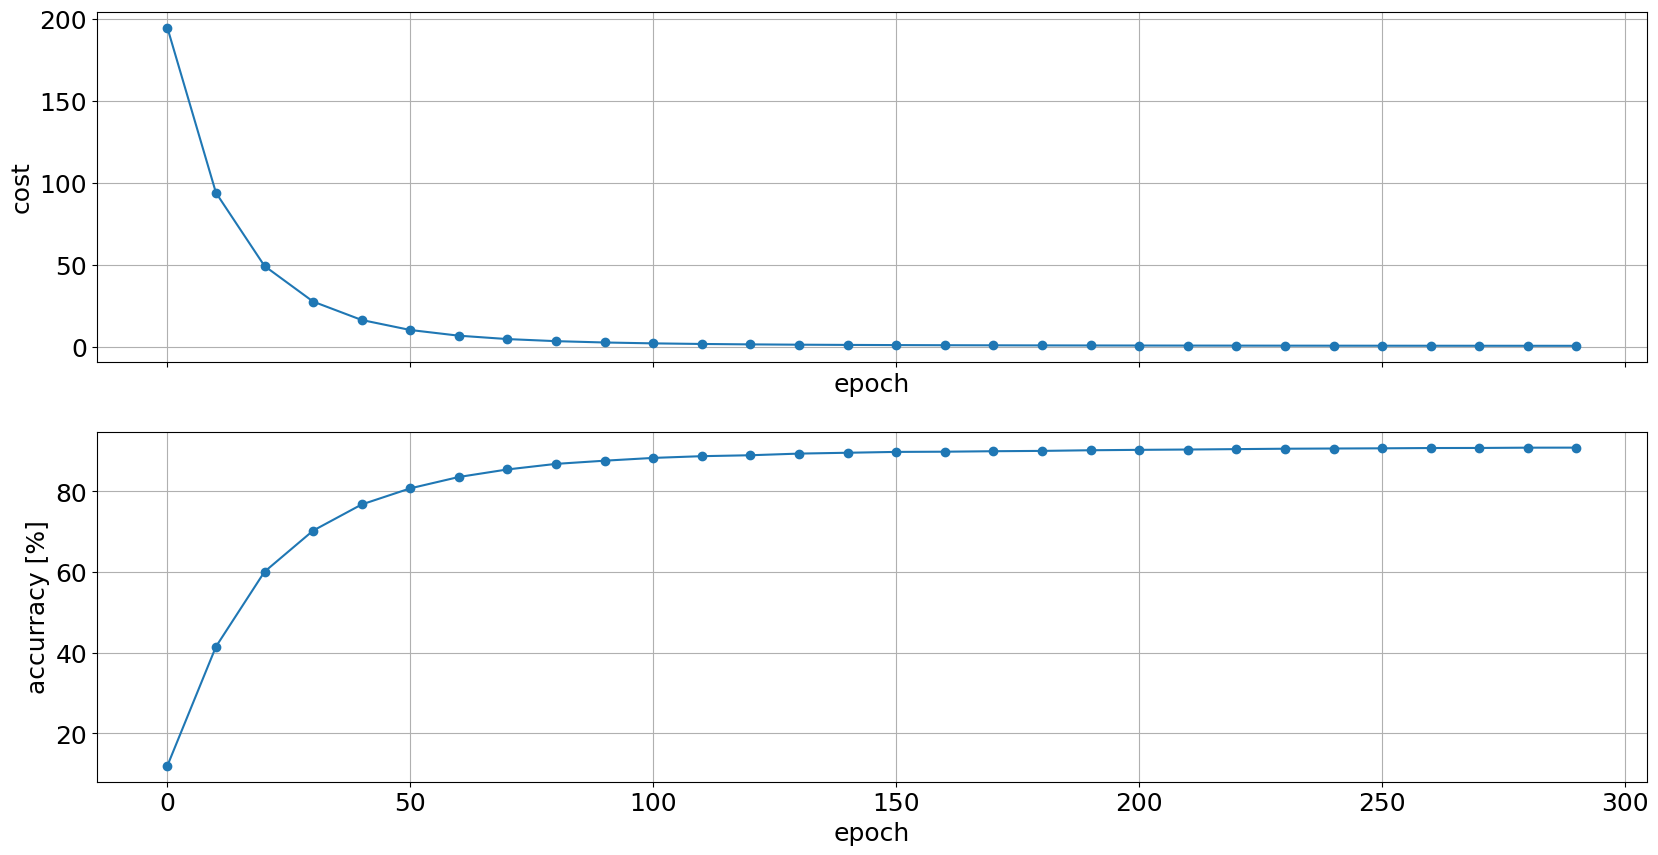

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
ax[0].plot([x * 10 for x in range(len(values))], values, 'o-')
ax[0].set_xlabel('epoch') ; ax[0].set_ylabel('cost')
ax[0].grid()
ax[1].plot([x * 10 for x in range(len(accurracies))], accurracies, 'o-')
ax[1].set_xlabel('epoch') ; ax[1].set_ylabel('accurracy [%]')
ax[1].grid()
plt.show()

In [27]:
# Calculam acuratetea pentru setul de test
# Aceasta presupune sa numaram cate predictii se potrivesc cu realitatea si sa exprimam acest lucru procentual
pred = np.argmax(softmax(test_x_all_ext, theta), axis=1)
actual = np.argmax(test_y_all, axis=1)
equalities = np.sum(pred == actual)
print("Test accuracy: %2.2f%%" % (100.0 * equalities / test_x_all_ext.shape[0]))

Test accuracy: 90.91%


In [28]:
# Calculam vectorii predictiilor precum si vectorul realitatii
pred = np.argmax(softmax(test_x_all_ext, theta), axis=1)
actual = np.argmax(test_y_all, axis=1)

# Confusion matrix va avea la intersectia linie/coloana cate sample-uri din clasa data de numarul liniei
# au fost prezise ca fiind facand parte din clasa data de numarul coloanei
conf_matrix: np.ndarray = np.zeros((k, k), dtype=int)
for i in range(pred.shape[0]):
    conf_matrix[actual[i], pred[i]] += 1
# ...

assert len(conf_matrix) == k
assert (sum(len(row) for row in conf_matrix)) == k ** 2

    
headers: List[str] = ['CnfMat'] + [f'pr: {x}' for x in range(k)] + ['all a'] 
table: List[Any] = []
for i in range(k):
    table.append([f'act: {i}'] + list(conf_matrix[i]) + [sum(conf_matrix[i])])
table.append(['all p'] + [sum(conf_matrix[:, i]) for i in range(k)] + [np.sum(conf_matrix).item()])

tab.table(table, headers, width=6)

╭────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────╮
│ CnfMat │  pr: 0 │  pr: 1 │  pr: 2 │  pr: 3 │  pr: 4 │  pr: 5 │  pr: 6 │  pr: 7 │  pr: 8 │  pr: 9 │  all a │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ act: 0 │    961 │      0 │      2 │      2 │      1 │      4 │      7 │      1 │      2 │      0 │    980 │
│ act: 1 │      0 │   1104 │      2 │      4 │      1 │      2 │      4 │      1 │     17 │      0 │   1135 │
│ act: 2 │     11 │     12 │    890 │     18 │     17 │      1 │     15 │     18 │     42 │      8 │   1032 │
│ act: 3 │      4 │      1 │     19 │    907 │      1 │     31 │      3 │     15 │     18 │     11 │   1010 │
│ act: 4 │      1 │      4 │      4 │      1 │    911 │      0 │     11 │      1 │      8 │     41 │    982 │
│ act: 5 │     12 │      4 │      2 │     39 │     15 │    753 │     16 │      9 │     33 │      9 │    892 │
│ act: 6 │